In [1]:
import numpy as np
import matplotlib.pyplot as plt
import compress_pickle as pickle
import scipy.stats
import os
from matplotlib.ticker import MultipleLocator

In [2]:

def dprime(hr, far):
    return scipy.stats.norm.ppf(hr) - scipy.stats.norm.ppf(far)

def compute_learning_curve(mouse_folder, window=200):
    session_files = sorted([f for f in os.listdir(mouse_folder) if f.endswith(".gz")])
    max_dprimes = []

    for filename in session_files:
        filepath = os.path.join(mouse_folder, filename)
        with open(filepath, "rb") as f:
            session_data = pickle.load(f)

        results = np.array(session_data["results"])
        n_trials = len(results)

        total_hits   = np.sum(results == "hit")
        total_misses = np.sum(results == "miss")
        total_FAs    = np.sum(results == "FA")
        total_CRs    = np.sum(results == "CR")

        hr  = (total_hits + 0.5) / (total_hits + total_misses + 1)
        far = (total_FAs  + 0.5) / (total_FAs  + total_CRs    + 1)
        overall_dp = dprime(hr, far)

        MA_DP = []
        if n_trials >= window:
            for start in range(n_trials - window + 1):
                w = results[start:start + window]
                hits   = np.sum(w == "hit")
                misses = np.sum(w == "miss")
                FAs    = np.sum(w == "FA")
                CRs    = np.sum(w == "CR")
                local_hr  = (hits + 0.5) / (hits + misses + 1)
                local_far = (FAs  + 0.5) / (FAs  + CRs    + 1)
                MA_DP.append(dprime(local_hr, local_far))

        max_dp = max(MA_DP) if MA_DP else overall_dp
        max_dprimes.append(max_dp)

    return max_dprimes, session_files

In [5]:
mouse_folders = {
    "BQK2_HP1": r"/Volumes/data/Lee_Yuna/projects/WT_behavior/BQK2_HP1_DONE",
    "BQK3_HP2": r"/Volumes/data/Lee_Yuna/projects/WT_behavior/BQK3_HP2_DONE",
    "BQK4_HP3": r"/Volumes/data/Lee_Yuna/projects/WT_behavior/BQK4_HP3_DONE",
    "BQV3_HP4": r"/Volumes/data/Lee_Yuna/projects/WT_behavior/BQV3_HP4_DONE",
    "BQV4_HP5": r"/Volumes/data/Lee_Yuna/projects/WT_behavior/BQV4_HP5_DONE",
    "BQV5_HP6": r"/Volumes/data/Lee_Yuna/projects/WT_behavior/BQV5_HP6_DONE"
}

In [6]:
dp_curves = {}
reverse_by_session = {}  # {mouse_name: [True/False per session]}

for mouse_name, folder in mouse_folders.items():
    dp_curve, session_files = compute_learning_curve(folder)

    flags = [("REVERSE" in f.upper()) for f in session_files]

    if dp_curve:
        dp_curves[mouse_name] = np.array(dp_curve)
        reverse_by_session[mouse_name] = np.array(flags[:len(dp_curve)], dtype=bool)
    else:
        print(f"No valid d' values for {mouse_name}")

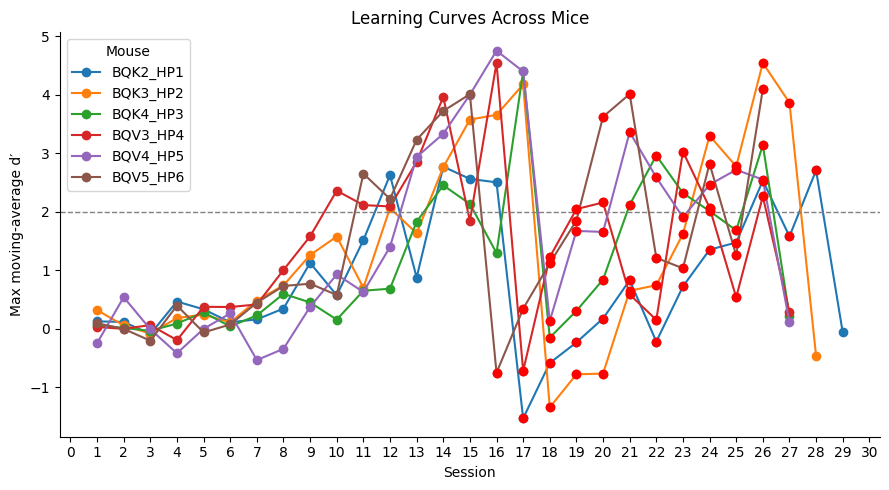

In [ ]:
plt.figure(figsize=(9, 5))
all_curves = []

for mouse_name, dp_curve in dp_curves.items():
    sessions = np.arange(1, len(dp_curve) + 1)
    flags = reverse_by_session[mouse_name]

    # base curve 
    plt.plot(sessions, dp_curve, marker="o", label=mouse_name)

    # overlay reverse-session markers in red
    plt.scatter(sessions[flags], dp_curve[flags], color="red", zorder=6)

    all_curves.append(dp_curve)

ax = plt.gca()
ax.axhline(2, linestyle="--", color="gray", linewidth=1)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Session")
plt.ylabel("Max moving-average d′")
plt.title("Learning Curves Across Mice")
plt.legend(title="Mouse")
plt.tight_layout()
plt.show()

In [67]:
from datetime import datetime
from pathlib import Path

dates = ['20251112', '20251113', '20251114', '20251115']

# convert first date
base_date = datetime.strptime(dates[0], "%Y%m%d")

# compute differences
day_diffs = [
    (datetime.strptime(d, "%Y%m%d") - base_date).days
    for d in dates
]

print(day_diffs)


raw_data_dir = '/Volumes/data/Lee_Yuna/projects/WT_behavior'

mouse_list = ['BQK2_HP1', 'BQK3_HP2', 'BQK4_HP3', 'BQV3_HP4', 'BQV4_HP5', 'BQV5_HP6']

session_days = {} # dictionary to hold session days for each mouse
for m in mouse_list: 
    mouse_raw_data_dir = os.path.join(raw_data_dir, m+'_DONE')
    print('Looking into the directory: ' + mouse_raw_data_dir)
    
    # get session files names sorted
    for type, endstring in zip(['learn', 'reverse'], ['*[1-9].gz', '*REVERSE.gz']):

        session_files = sorted([p.name for p in list(Path(mouse_raw_data_dir).glob(endstring))])
    
        # get dates from filenames
        dates = [filename[0:8] for filename in session_files]

        # convert the days according to the first date
        base_date = datetime.strptime(dates[0], "%Y%m%d")

        session_days[(m,type)] = [(datetime.strptime(d, "%Y%m%d") - base_date).days for d in dates]
    
session_days.keys()
print(session_days[('BQK2_HP1','learn')])
    

[0, 1, 2, 3]
Looking into the directory: /Volumes/data/Lee_Yuna/projects/WT_behavior/BQK2_HP1_DONE
Looking into the directory: /Volumes/data/Lee_Yuna/projects/WT_behavior/BQK3_HP2_DONE
Looking into the directory: /Volumes/data/Lee_Yuna/projects/WT_behavior/BQK4_HP3_DONE
Looking into the directory: /Volumes/data/Lee_Yuna/projects/WT_behavior/BQV3_HP4_DONE
Looking into the directory: /Volumes/data/Lee_Yuna/projects/WT_behavior/BQV4_HP5_DONE
Looking into the directory: /Volumes/data/Lee_Yuna/projects/WT_behavior/BQV5_HP6_DONE
[0, 1, 2, 3, 5, 6, 9, 12, 13, 21, 22, 23, 25, 27, 28]


In [ ]:
dp_curves

In [127]:
def pad_1d_with_nan(arr_list):
    max_len = max(a.shape[0] for a in arr_list)
    out = []
    for a in arr_list:
        a = np.asarray(a, dtype=float)          # needed because NaN is float
        pad = max_len - a.shape[0]
        out.append(np.pad(a, (0, pad), constant_values=np.nan))
    return out  # list of 1D arrays, all same length

# usage
pd_train = pad_1d_with_nan([
    dp_curves[m][:len(session_days[(m,'learn')])+1] 
    for m in mouse_list])
pd_reverse = pad_1d_with_nan([
    dp_curves[m][len(session_days[(m,'learn')])+1:] 
    for m in mouse_list])


In [138]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6

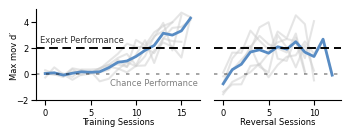

In [188]:
# can have parameter to convert cm to inches
cm2inch = 1/2.54
f0, axes = plt.subplots(1,2,figsize=(10*cm2inch, 3*cm2inch), gridspec_kw={'width_ratios':[18,14],'wspace': 0.1}) 

axes[0].plot(np.nanmean(pd_train, axis=0), color = "#588cc4", lw = 2, zorder = 3)
axes[1].plot(np.nanmean(pd_reverse, axis=0), color = "#588cc4", lw = 2, zorder = 3)

for m in mouse_list: 
    len_training = len(session_days[(m,'learn')])
    # print(dp_curves[m][:len_training])

    axes[0].plot(dp_curves[m][:len_training+1], color = "#CDCDCD", alpha = 0.5, lw = 1.5, zorder = 1)  # light blue for training
    axes[1].plot(dp_curves[m][len_training+1:], color = "#CDCDCD", alpha = 0.5, lw = 1.5, zorder = 1)  # light blue for reverse

    # add the random performance and expert performance lines 
    for i in range(2):
        l0 = axes[i].axhline(0, linestyle="--", color="black", lw = 1.2, alpha = 0.08, zorder = 4)
        l0 .set_dashes([2, 4])  # 2 points on, 4 points off
        l2 = axes[i].axhline(2, linestyle="--", color="black", lw = 1.2, alpha = 0.5, zorder = 4)
        # set a custom dash pattern
        l2.set_dashes([5,3])  # 10 points on, 6 points off
        axes[i].set_ylim(-2, 5)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
    axes[0].set_xlim(-1,17)
    axes[1].set_xlim(-1,13)

    axes[0].set_xlabel('Training Sessions', labelpad=0)
    axes[1].set_xlabel('Reversal Sessions', labelpad=0)
    axes[0].set_ylabel("Max mov d′", labelpad=-2)

    for ax in axes:
        ax.tick_params(axis='x', pad=2)  # smaller = closer
        ax.tick_params(axis='y', pad=2)

    axes[1].spines['left'].set_visible(False)
    axes[1].set_yticks([])

# add labels
axes[0].text(4, 3, 'Expert Performance', va='top', ha='center', alpha=0.8)
axes[0].text(12, -1, 'Chance Performance', va='bottom', ha='center', alpha=0.5)

# add reverse direction arrow
lefttemp = 18
# axes[0].plot([lefttemp, lefttemp],[-2,5], color='black', lw=2, zorder=5, clip_on=False, alpha=0.6, solid_capstyle='butt')
# axes[0].text(lefttemp, 1.5, 'Reversal of Brushing', va='center', ha='center', alpha=0.8, rotation=90)

plt.savefig('/Volumes/data/Lee_Yuna/projects/WT_behavior/all_mice_learning_curves.pdf', dpi=300, bbox_inches='tight')

# numbers in inches, 18 x 21 cm for A4 paper